# Data Analysis Pipeline for TAX1BP1 manuscript:

## Load packages and data

The analysis pipeline uses 'autoprot' developed in our lab (https://doi.org/10.1101/2024.01.18.571429)

Autoprot is implemented in Python ≥ 3.9 and can be downloaded from https://github.com/ag-warscheid/autoprot. Online documentation is available at https://ag-warscheid.github.io/autoprot/.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os

import plotly.graph_objects as go
import plotly.express as px

from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis
from autoprot_dev import analysis as ana

plt.rcParams['pdf.fonttype'] = 42
pd.set_option("display.max_columns", 10)

TEAL = "#C1D9D4"
DGREEN = "#3B592D"
GREEN = "#7E8C49"
ORANGE = "#D98452"
RED = "#BF4C41"

Checking R installation...
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)
Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.19'
is available with R version '4.4'; see https://bioconductor.org/install
Loading required package: devtools
Loading required package: usethis
Attaching package: ‘devtools’
The 

In [2]:
df = pd.read_csv("txt/proteinGroups.txt", sep='\t', low_memory=False)
df.sample(1)

Protein IDs  \
436  P05089;A0A5F9ZH78;P05089-2;A0A5F9ZGN6;P05089-3   

                      Majority protein IDs Peptide counts (all)  \
436  P05089;A0A5F9ZH78;P05089-2;A0A5F9ZGN6            5;5;5;4;1   

    Peptide counts (razor+unique) Peptide counts (unique)  ...  \
436                     5;5;5;4;1               5;5;5;4;1  ...   

                             Best MS/MS Oxidation (M) site IDs  \
436  467516;593323;598383;682272;714576            732;733;734   

    Oxidation (M) site positions    Taxonomy IDs  Taxonomy names  
436                  200;212;276  -1;-1;-1;-1;-1            ;;;;  

[1 rows x 293 columns]

In [3]:
df = pp.cleaning(df)

4409 rows before filter operation.
3934 rows after filter operation.


In [4]:
df['Gene names 1st'] = df['Gene names'].str.split(';').str[0]

## Visualization of missing values in the complete analysis:

True

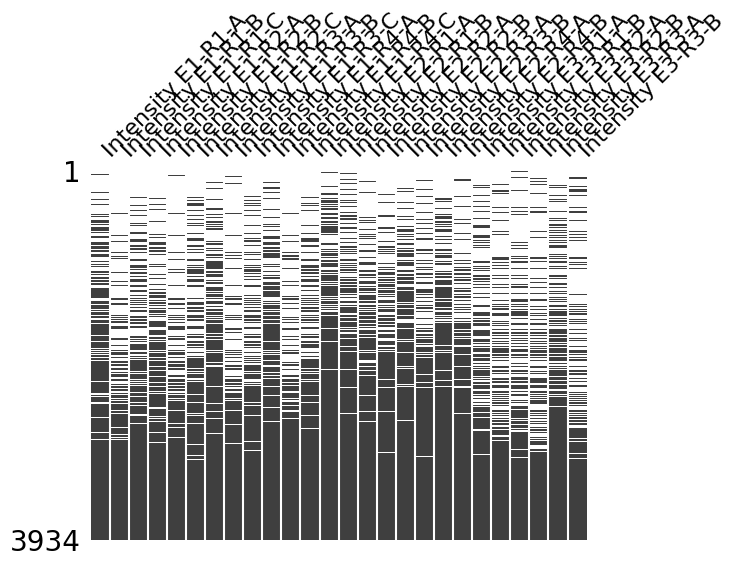

In [5]:
cois1 = sorted(df.filter(regex='Intensity ').columns.to_list())
df[cois1] = df[cois1].replace(0, np.nan)
ana.miss_analysis(df, cois1,text=False, vis=False, extra_vis=True)

## Inspection of channel intensities:

In [6]:
df, log_int_cols = pp.log(df, cols=df.filter(regex='Intensity ').columns.to_list(), base=2, return_cols=True)

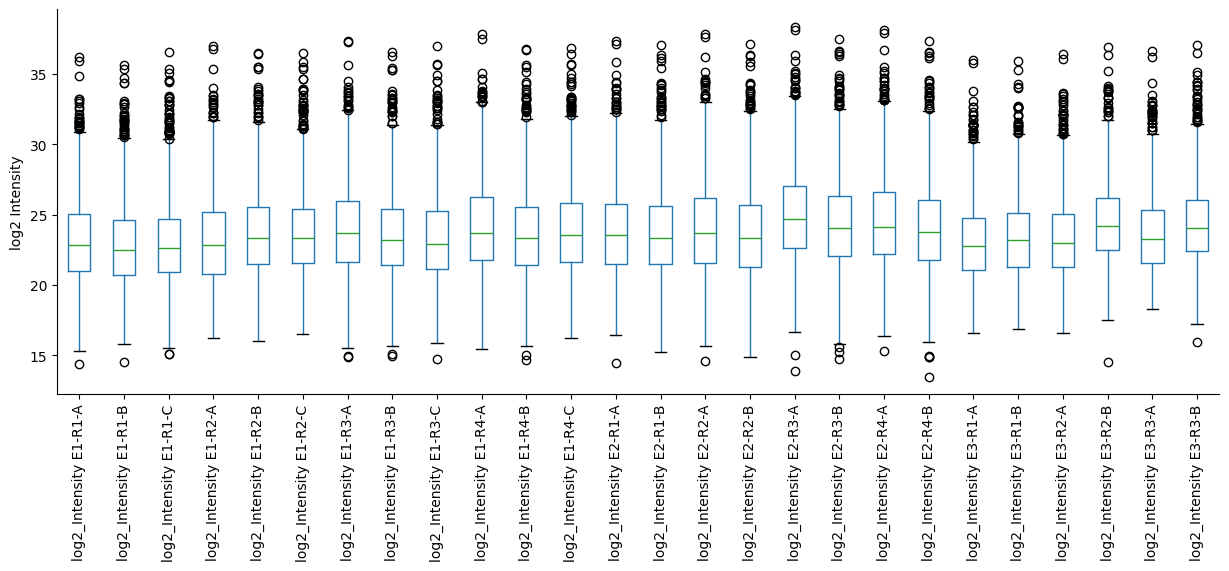

In [7]:
fig = vis.boxplot(df, reps=log_int_cols, labels=[x for x in log_int_cols], ret_fig=True, ylabel='log2 Intensity')
ax = fig.get_axes()[0]
ax.tick_params(axis='x', rotation=90)

## Selective imputation of proteins missing in all Free Turbo lanes but having values in all reps of other lanes:

In [8]:
# Function to impute missing values per row
def impute_per_row(row):
    downshift = 5
    width = .5
    
    # Ensure the row is numeric
    # row = pd.to_numeric(row, errors='coerce')
    
    var = np.std(row)
    mean = np.mean(row)

    mean_ = mean - downshift * var
    var_ = var * width

    rnd = list(np.random.normal(mean_, var_, size=np.isnan(row).sum()))
    
    idx_noCtrl = row[row.isnull()].index
            
    for i, idx in enumerate(idx_noCtrl):
        row[idx] = rnd[i]
                
    return row

#### Experiment 1:

In [9]:
## Filter criteria
filter_criteria =  (df.filter(regex='log2_Intensity .*E1.*A').sum(axis=1) == 0) & (df.filter(regex='log2_Intensity .*E1.*B').gt(0).all(axis=1)) & (df.filter(regex='log2_Intensity .*E1.*C').gt(0).all(axis=1))

# Apply the filter criteria
filtered_df = df.loc[filter_criteria].copy()
cols = filtered_df.filter(regex='log2_Intensity .*E1').columns.to_list()
filtered_df[cols] = filtered_df[cols].apply(impute_per_row, axis=1)

# Update the original DataFrame
df.loc[filter_criteria, cols] = filtered_df[cols]

#### Experiment 3:

In [10]:
## Filter criteria
filter_criteria =  (df.filter(regex='log2_Intensity .*E3.*A').sum(axis=1) == 0) & (df.filter(regex='log2_Intensity .*E3.*B').gt(0).all(axis=1))

# Apply the filter criteria
filtered_df = df.loc[filter_criteria].copy()
cols = filtered_df.filter(regex='log2_Intensity .*E3').columns.to_list()
filtered_df[cols] = filtered_df[cols].apply(impute_per_row, axis=1)

# Update the original DataFrame
df.loc[filter_criteria, cols] = filtered_df[cols]

#### Experiment 2:

In [11]:
# Function to impute missing values per row
def impute_per_row(row):
    downshift = 2.8
    width = .5
    
    # Ensure the row is numeric
    # row = pd.to_numeric(row, errors='coerce')
    
    var = np.std(row)
    mean = np.mean(row)

    mean_ = mean - downshift * var
    var_ = var * width

    rnd = list(np.random.normal(mean_, var_, size=np.isnan(row).sum()))
    
    idx_noCtrl = row[row.isnull()].index
            
    for i, idx in enumerate(idx_noCtrl):
        row[idx] = rnd[i]
                
    return row

In [12]:
## Filter criteria
filter_criteria =  (df.filter(regex='log2_Intensity .*E2.*A').sum(axis=1) == 0) & (df.filter(regex='log2_Intensity .*E2.*B').gt(0).all(axis=1))

# Apply the filter criteria
filtered_df = df.loc[filter_criteria].copy()
cols = filtered_df.filter(regex='log2_Intensity .*E2').columns.to_list()
filtered_df[cols] = filtered_df[cols].apply(impute_per_row, axis=1)

# Update the original DataFrame
df.loc[filter_criteria, cols] = filtered_df[cols]

## PCA analysis of intensities:

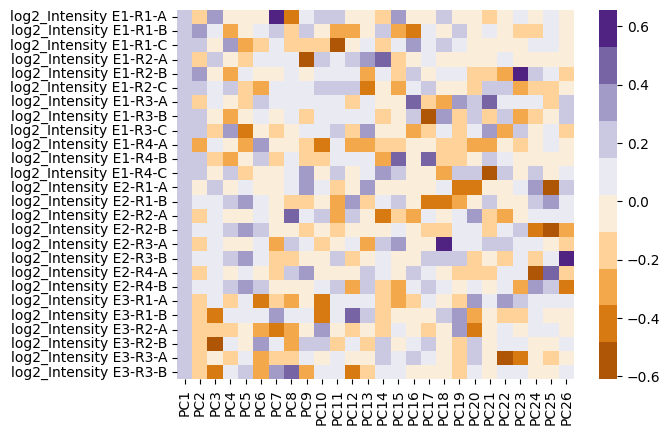

In [13]:
norm_int = df[log_int_cols]
pca = ana.AutoPCA(norm_int, rlabels=norm_int.index, clabels=[x for x in norm_int.columns.to_list()])
pca.corr_comp()

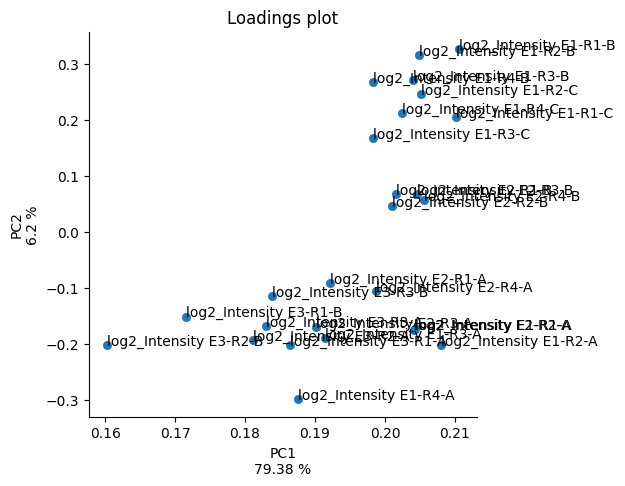

In [14]:
pca.loading_plot(pc1=1, pc2=2, labeling=True)

## Merging with category list:

In [15]:
marker = pd.read_csv("category_list.txt", sep='\t')
marker.sample(1)

UNIPROT IDs Gene names 1st entry Gene names  (synonym )  \
16786      Q9H6R0                DHX33                  DDX33   

                                 Protein names (UniProt)  \
16786  ATP-dependent RNA helicase DHX33 (Fragment);AT...   

       Transmembrane (UniProt)  Intramembrane (UniProt) category  
16786                      NaN                      NaN      NaN

### Merge function:

In [16]:
import pandas as pd
import numpy as np

def data_merge(df1, df3, df1_col, df3_col, cat_cols=None, num_cols=None, ignore_case=True, how='left'):
    if df1_col is None or df3_col is None:
        return "Provide the dataframes 'df_col1' as left dataframe and 'df_col2' as right dataframe for the merge"

    # Add UID to both dataframes
    df1['UID'] = range(1, df1.shape[0] + 1)
    df3['UID'] = range(1, df3.shape[0] + 1)

    # Convert entries to strings and explode and dehyphenate the columns
    df1_exploded = df1.assign(**{df1_col: df1[df1_col].astype(str).str.split(';')}).explode(df1_col)
    df1_exploded[df1_col] = df1_exploded[df1_col].str.split('-').apply(lambda x: x[0])
    df3_exploded = df3.assign(**{df3_col: df3[df3_col].astype(str).str.split(';')}).explode(df3_col)
    df3_exploded[df3_col] = df3_exploded[df3_col].str.split('-').apply(lambda x: x[0])


    # Merge the dataframes
    if ignore_case:
        df1_exploded[df1_col] = df1_exploded[df1_col].str.upper()
        df3_exploded[df3_col] = df3_exploded[df3_col].str.upper()

    merged_df = df1_exploded.merge(df3_exploded, left_on=df1_col, right_on=df3_col, how=how, suffixes=('', '_y'))

    # Handle cat_cols
    if cat_cols is None:
        cat_cols = df3.columns.tolist()

    for col in cat_cols:
        if col in merged_df.columns:
            merged_df[col] = merged_df.groupby(df1_col)[col].transform(lambda x: ';'.join(map(str, x.dropna())))

    # Replace multiple 'nan' entries with a single NaN
    merged_df[cat_cols] = merged_df[cat_cols].replace('nan', np.nan).replace('nan;nan', np.nan)

    # Handle num_cols
    if num_cols is not None:
        for col in num_cols:
            if col in merged_df.columns:
                merged_df[col] = merged_df.groupby(df1_col)[col].transform(np.median)

    # Drop duplicates and reset index
    merged_df = merged_df.drop_duplicates(subset='UID').reset_index(drop=True)
    merged_df.drop(merged_df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
    return merged_df

In [17]:
df_merged = data_merge(df, marker, 'Majority protein IDs', 'UNIPROT IDs', 
           cat_cols=['Transmembrane (UniProt)','Intramembrane (UniProt)','category'], num_cols=None, ignore_case=True, how='left')

In [18]:
df_merged['category'] = df_merged['category'].str.split(";").str.get(0)

In [19]:
df_merged.loc[df_merged['Gene names 1st'] == 'VCP', 'Gene names 1st'] = 'p97'

# Experiment 1: Identification of proximity partners of the autophagy receptor TAX1BP1

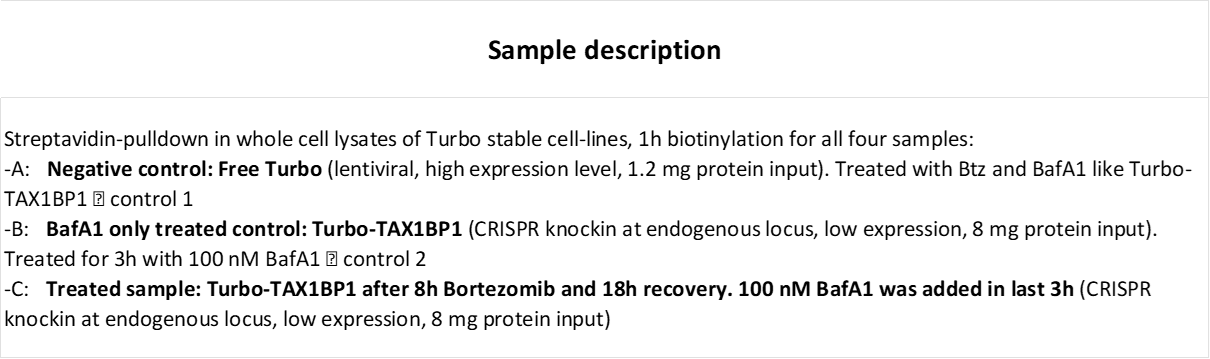

Ratios to caclulate:

- Ratio C vs A (Turbo-TAX1BP1 Aggrephagy vs Free-Turbo Aggrephagy)
- Ratio C vs B (Turbo-TAX1BP1 Aggrephagy vs Untreated)

## Data preprocessing:

In [20]:
df1 = df_merged.copy(deep=True)

### Selecting analysis type:

In [21]:
val = 'log2_Intensity'

In [22]:
val = 'log2_Intensity'

laneA = [val + ' E1-R1-A', val + ' E1-R2-A', val + ' E1-R3-A', val + ' E1-R4-A']

laneB = [val + ' E1-R1-B', val + ' E1-R2-B', val + ' E1-R3-B', val + ' E1-R4-B']

laneC = [val + ' E1-R1-C', val + ' E1-R2-C', val + ' E1-R3-C', val + ' E1-R4-C']

lanes = [laneA, laneB, laneC]

sumlanes = laneA + laneB + laneC

#### Data processing loop:

In [23]:
for lane, i in zip(lanes, range(1,5)):
    df1[lane] = df1[lane].replace(0, np.nan)
    df1 = pp.remove_non_quant(df1, sumlanes)
    ### Filtering for 2/4 reps:
    df1 = pp.filter_vv(df1, [lane], n=2, valid_values=True)
    df_imp = pp.imp_seq(df1, lane)    
    lane = df_imp.filter(regex='_imputed').columns.to_list()
    df_imp, lane = pp.quantile_norm(df_imp, lane, return_cols=True)
    lane = df_imp.filter(regex='_imputed_normalized').columns.to_list()
    # Generate the DataFrame name as a string
    df_name = "df_" + str(i)
    exec(f"{df_name} = df_imp")

3934 rows before filter operation.
3674 rows after filter operation.
3674 rows before filter operation.
2965 rows after filter operation.
2965 rows before filter operation.
2965 rows after filter operation.
2965 rows before filter operation.
1936 rows after filter operation.
1936 rows before filter operation.
1936 rows after filter operation.
1936 rows before filter operation.
1801 rows after filter operation.


### Merging to preserve index:

In [24]:
merge1 = pd.merge(df_merged, df_1,how="left", on ='id', suffixes=('', '_y'))
merge1.drop(merge1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

merge2 = pd.merge(merge1, df_2,how="left", on ='id', suffixes=('', '_y'))
merge2.drop(merge2.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

merge3 = pd.merge(merge2, df_3,how="left", on ='id', suffixes=('', '_y'))
merge3.drop(merge3.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [25]:
df_exp1 = merge3.copy(deep=True)

### Selecting lanes for ratios:

In [26]:
laneA = ['log2_Intensity.E1.R1.A_imputed_normalized','log2_Intensity.E1.R2.A_imputed_normalized',
        'log2_Intensity.E1.R3.A_imputed_normalized','log2_Intensity.E1.R4.A_imputed_normalized']
laneB = ['log2_Intensity.E1.R1.B_imputed_normalized','log2_Intensity.E1.R2.B_imputed_normalized',
        'log2_Intensity.E1.R3.B_imputed_normalized','log2_Intensity.E1.R4.B_imputed_normalized']
laneC = ['log2_Intensity.E1.R1.C_imputed_normalized','log2_Intensity.E1.R2.C_imputed_normalized',
        'log2_Intensity.E1.R3.C_imputed_normalized','log2_Intensity.E1.R4.C_imputed_normalized']

lanes = [laneA, laneB, laneC]

### Calculate ratios

For all reps:

In [27]:
for i in range(1,5):
    df_exp1[f"Ratio " + val + " E1 Lane-C vs Lane-A Rep_" + str(i)] = df_exp1[laneC[i-1]] - df_exp1[laneA[i-1]]
    
    df_exp1[f"Ratio " + val + " E1 Lane-C vs Lane-B Rep_" + str(i)] = df_exp1[laneC[i-1]] - df_exp1[laneB[i-1]]

### Ratio corr maps:

<Figure size 2000x1000 with 0 Axes>

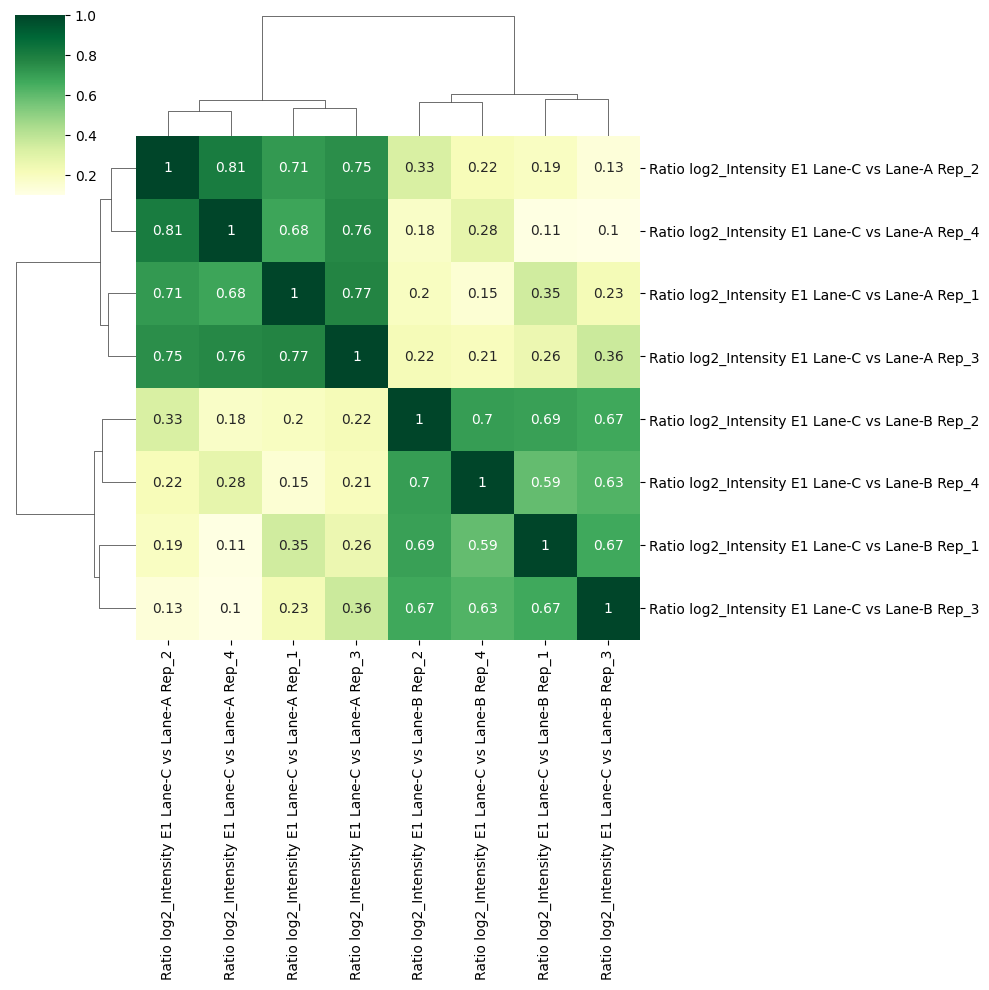

In [28]:
plt.figure(figsize=(20,10))
vis.corr_map(df_exp1, df_exp1.filter(regex='Ratio ').columns.to_list(), cluster=True,
    annot=True)
##plt.savefig(r"F:\EXPERIMENTS\HD_Collaborations\AG_Buchberger\01_AB001_TAX1BP1_TurboID\Rep1_2\plots\RatiovsIntensity_df3.pdf")

### Ratio-Intensity plots:

In [29]:
log_ratio_cols = df_exp1.filter(regex='Ratio log2_Intensity E1 Lane-C vs Lane-A Rep').columns.to_list()

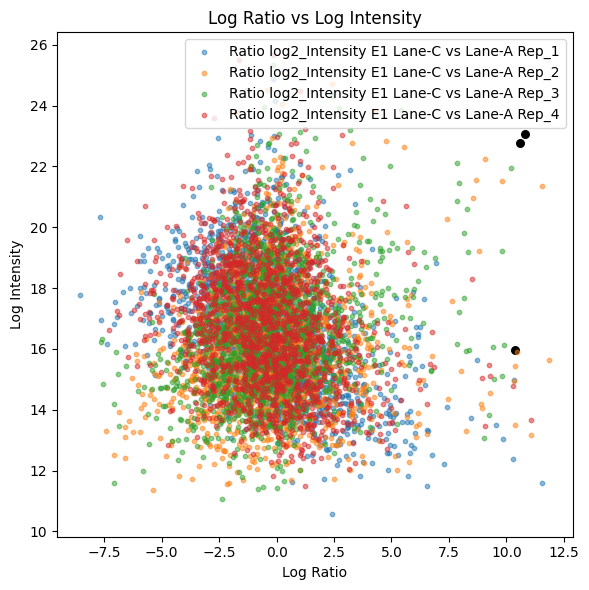

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single plot
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `df_exp1` and `log_ratio_cols` are already defined
int_cols = df_exp1.filter(regex='Intensity ').columns.to_list()

for idx, col in enumerate(log_ratio_cols):
    # Normalized values are plotted on top of the non-normalized values for comparison
    ax.scatter(df_exp1[col],
               np.log(df_exp1[int_cols[idx]]),
               label=col,
               alpha=0.5,
               s=10)
    temp = df_exp1[df_exp1['Gene names 1st'] == "TAX1BP1"]
    ax.scatter(temp[col],
               np.log(temp[int_cols[idx]]),
               label=None,
               alpha=1,
               color='black',
               s=30,
               linewidths=1)

# Set the axis labels, title, and add a legend
ax.set_xlabel('Log Ratio')
ax.set_ylabel('Log Intensity')
ax.set_title('Log Ratio vs Log Intensity')
ax.legend()

plt.tight_layout()
plt.show()


## LIMMA ANALYSIS


In [31]:
Ratio1 = df_exp1.filter(regex='Ratio.*Lane-C vs Lane-A').columns.to_list()
df_exp1_CvsA = pp.filter_vv(df_exp1, [Ratio1], n=4, valid_values=True)
df_exp1_CvsA = ana.limma(df_exp1_CvsA, [Ratio1], cond="_E1_Lane-C vs Lane-A")

3934 rows before filter operation.
1801 rows after filter operation.
LIMMA: Assuming a one sample test


In [32]:
Ratio2 = df_exp1.filter(regex='Ratio.*Lane-C vs Lane-B').columns.to_list()
df_exp1_CvsB = pp.filter_vv(df_exp1, [Ratio2], n=4, valid_values=True)
df_exp1_CvsB = ana.limma(df_exp1_CvsB, [Ratio2], cond="_E1_Lane-C vs Lane-B")

3934 rows before filter operation.
1801 rows after filter operation.
LIMMA: Assuming a one sample test


## Volcano Plots:

### Lane-C vs Lane-A

#### With all categories marked:

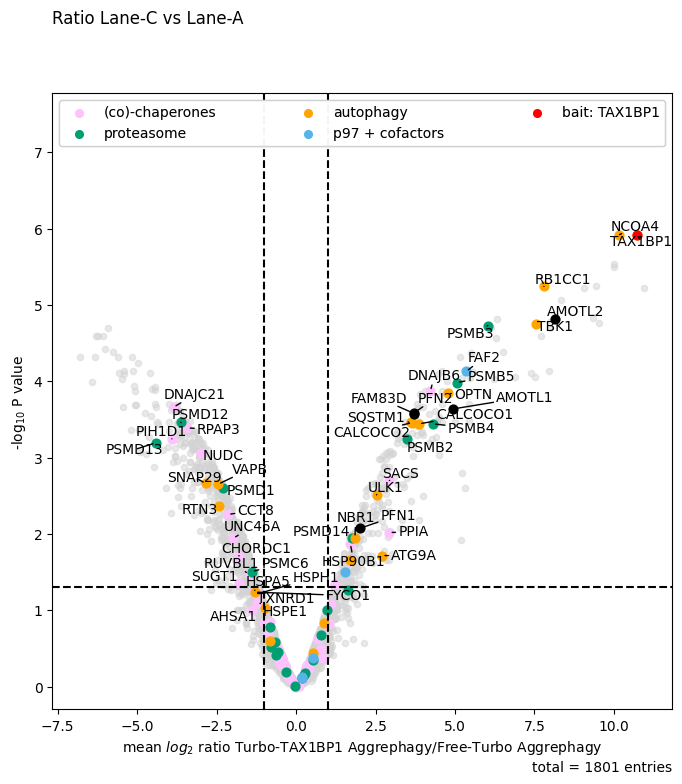

In [34]:
fig = vis.volcano(df_exp1_CvsA,
title = "Ratio Lane-C vs Lane-A",
log_fc_colname="logFC_E1_Lane-C vs Lane-A", 
p_colname="adj.P.Val_E1_Lane-C vs Lane-A",  
p_thresh=0.05,
log_fc_thresh = 1,
# show_legend = False,
annotate_colname='Gene names 1st',
annotate_density = 150,
annotate='highlight', 
highlight=[
        df_exp1_CvsA[df_exp1_CvsA['category']=='co-chaperones'].index,
        df_exp1_CvsA[df_exp1_CvsA['category']=='proteasome'].index,
           df_exp1_CvsA[df_exp1_CvsA['category']=='autophagy'].index,
           df_exp1_CvsA[df_exp1_CvsA['category']=='p97 and cofactors'].index,
           df_exp1_CvsA[df_exp1_CvsA['Gene names 1st']=='TAX1BP1'].index,
        df_exp1_CvsA[df_exp1_CvsA['Gene names 1st'].isin(['AMOTL1', 'AMOTL2', 'FAM83D','PFN1','PFN2'])].index],
kwargs_highlight=[{'color': '#fec2ff', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': '(co)-chaperones', # set highlight label
    },
    {'color': '#009E73', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'proteasome', # set highlight label
    },
    {'color': 'orange', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'autophagy', # set highlight label
    },
    {'color': '#56B4E9', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'p97 + cofactors', # set highlight label
    },
    {'color': 'red', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'bait: TAX1BP1', # set highlight label
    },
    {'color': 'black', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': None, # set highlight label
    },],
kwargs_both_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
            
kwargs_log_fc_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
kwargs_p_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
kwargs_ns={
    'color': 'lightgrey', # set highlight color to red
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    })

for ax in fig.get_axes():
    ax.set_xlabel(r"mean $ log_{2}$ ratio Turbo-TAX1BP1 Aggrephagy/Free-Turbo Aggrephagy")
    ax.set_ylabel(r"-log$_{10}$ P value")
plt.savefig("plots/1_Volcano_Turbo-TAX1BP1 vs Free-Turbo_highlighted_annotated_v01.pdf")

#### Volcano plot: Plotly

In [35]:
df_exp1_CvsA['negative_p-value'] = np.log10(df_exp1_CvsA['P.Value_E1_Lane-C vs Lane-A']) * (-1)

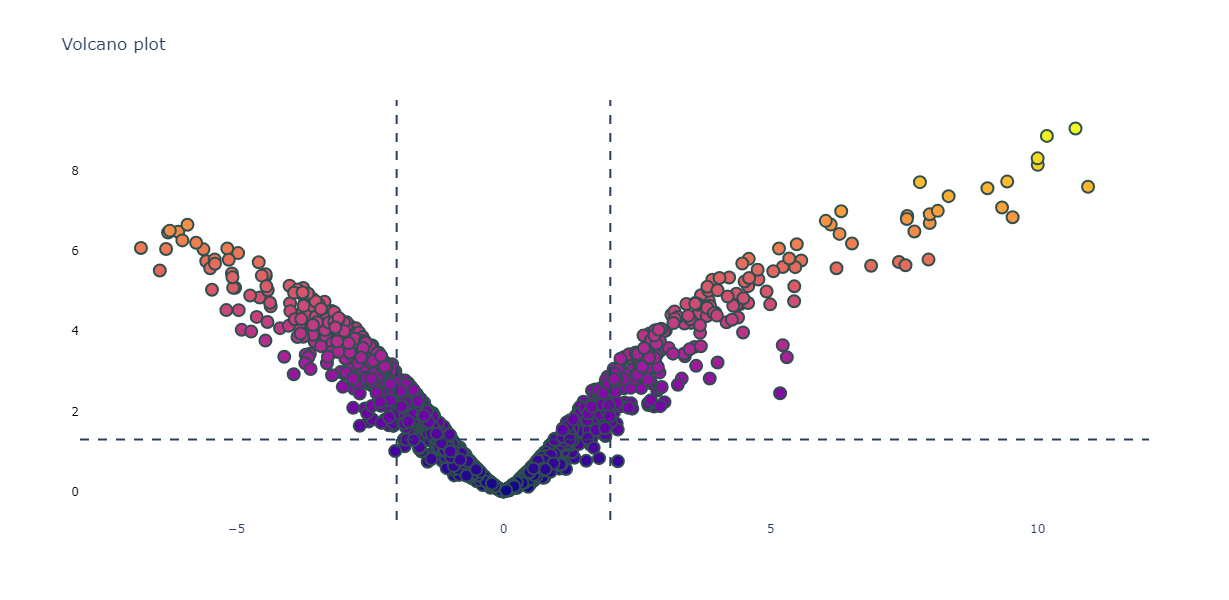

In [36]:
fig = go.Figure()
trace1 = go.Scatter(
 x=df_exp1_CvsA['logFC_E1_Lane-C vs Lane-A'],
 y=df_exp1_CvsA['negative_p-value'],
 mode='markers',
    marker_color=df_exp1_CvsA['negative_p-value'],
 name='6hrs',
 hovertext=list(df_exp1_CvsA["Gene names"])
)

fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
# fig.add_trace(trace4)
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.add_hline(y=1.3, line_dash="dash")
fig.add_vline(x=2, line_dash="dash")
fig.add_vline(x=-2, line_dash="dash")
fig.update_layout(title='Volcano plot',
                 autosize=False,
                 width=800,
                 height=600)
fig.update_layout(plot_bgcolor="white")
fig.update_yaxes(color='black', layer='above traces')
fig.show()

### Lane-C vs Lane-B

#### With all categories marked:

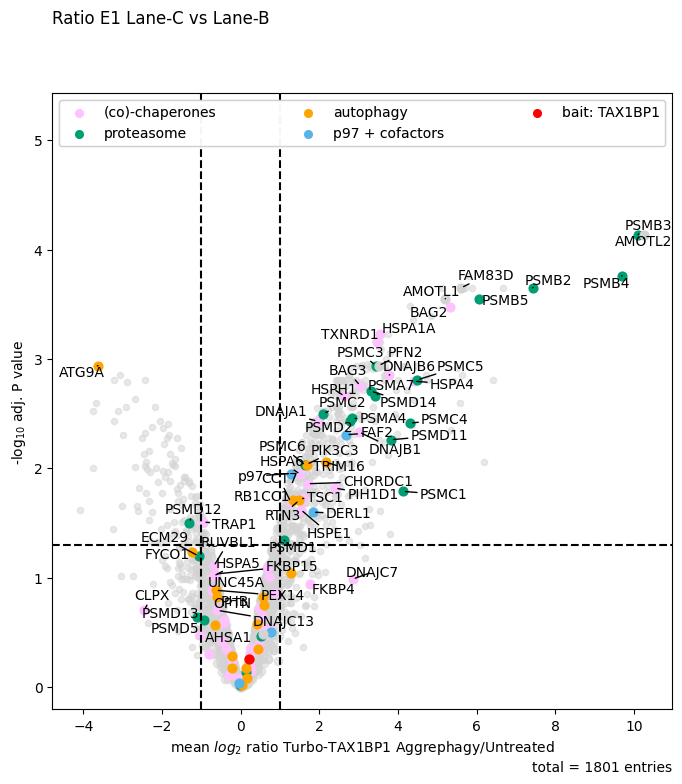

In [37]:
fig = vis.volcano(df_exp1_CvsB,
title = "Ratio E1 Lane-C vs Lane-B",
log_fc_colname="logFC_E1_Lane-C vs Lane-B", 
p_colname="adj.P.Val_E1_Lane-C vs Lane-B",  
p_thresh=0.05,
log_fc_thresh = 1,
# show_legend = False,
annotate_colname='Gene names 1st',
annotate_density = 200,
annotate='highlight', 
highlight=[
        df_exp1_CvsB[df_exp1_CvsB['category']=='co-chaperones'].index,
        df_exp1_CvsB[df_exp1_CvsB['category']=='proteasome'].index,
           df_exp1_CvsB[df_exp1_CvsB['category']=='autophagy'].index,
           df_exp1_CvsB[df_exp1_CvsB['category']=='p97 and cofactors'].index,
           df_exp1_CvsB[df_exp1_CvsB['Gene names 1st']=='TAX1BP1'].index,
        df_exp1_CvsB[df_exp1_CvsB['Gene names 1st'].isin(['AMOTL1', 'AMOTL2', 'FAM83D','PFN1','PFN2'])].index],
kwargs_highlight=[{'color': '#fec2ff', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': '(co)-chaperones', # set highlight label
    },
    {'color': '#009E73', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'proteasome', # set highlight label
    },
    {'color': 'orange', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'autophagy', # set highlight label
    },
    {'color': '#56B4E9', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'p97 + cofactors', # set highlight label
    },
    {'color': 'red', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'bait: TAX1BP1', # set highlight label
    },
    {'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': None, # set highlight label
    },],
kwargs_both_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
            
kwargs_log_fc_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
kwargs_p_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
kwargs_ns={
    'color': 'lightgrey', # set highlight color to red
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    })

for ax in fig.get_axes():
    ax.set_xlabel(r"mean $ log_{2}$ ratio Turbo-TAX1BP1 Aggrephagy/Untreated")
    ax.set_ylabel(r"-log$_{10}$ adj. P value")
plt.savefig("plots/2_Volcano_Turbo-TAX1BP1 vs Untreated_highlighted_annotated_v01.pdf")

#### Volcano plot: Plotly

In [38]:
df_exp1_CvsB['negative_Adj.p-value'] = np.log10(df_exp1_CvsB['P.Value_E1_Lane-C vs Lane-B']) * (-1)

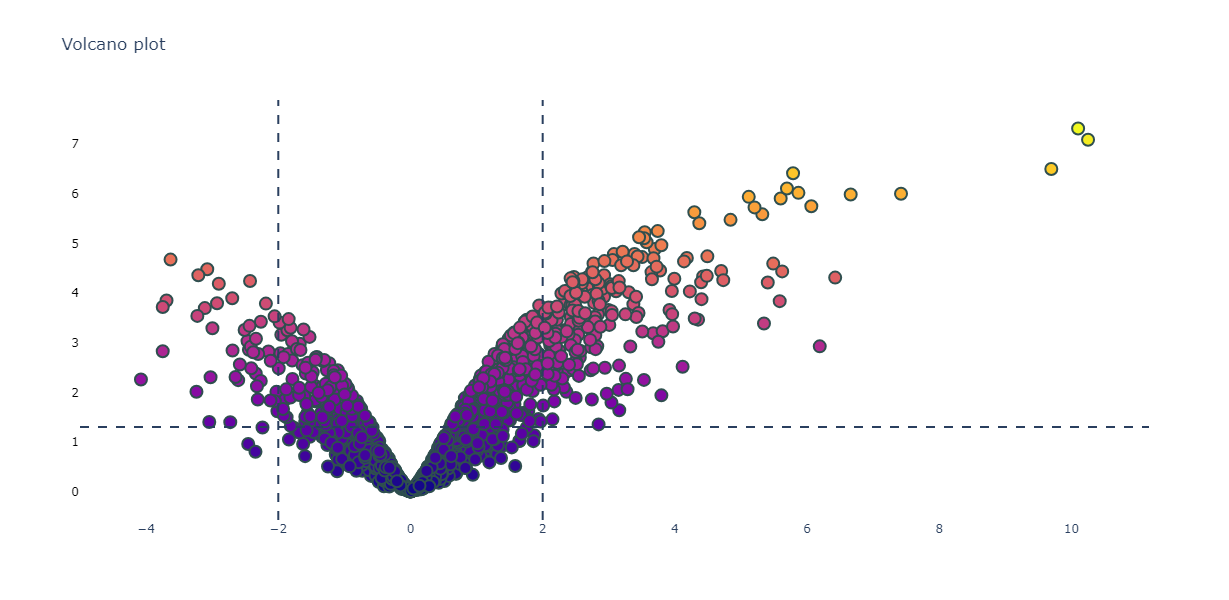

In [39]:
fig = go.Figure()
trace1 = go.Scatter(
 x=df_exp1_CvsB['logFC_E1_Lane-C vs Lane-B'],
 y=df_exp1_CvsB['negative_Adj.p-value'],
 mode='markers',
    marker_color=df_exp1_CvsB['negative_Adj.p-value'],
 name='6hrs',
 hovertext=list(df_exp1_CvsB["Gene names"])
)

fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
# fig.add_trace(trace4)
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.add_hline(y=1.3, line_dash="dash")
fig.add_vline(x=2, line_dash="dash")
fig.add_vline(x=-2, line_dash="dash")
fig.update_layout(title='Volcano plot',
                 autosize=False,
                 width=800,
                 height=600)
fig.update_layout(plot_bgcolor="white")
fig.update_yaxes(color='black', layer='above traces')
fig.show()

# Experiment 2: Identification of proximity partners of PLAA:

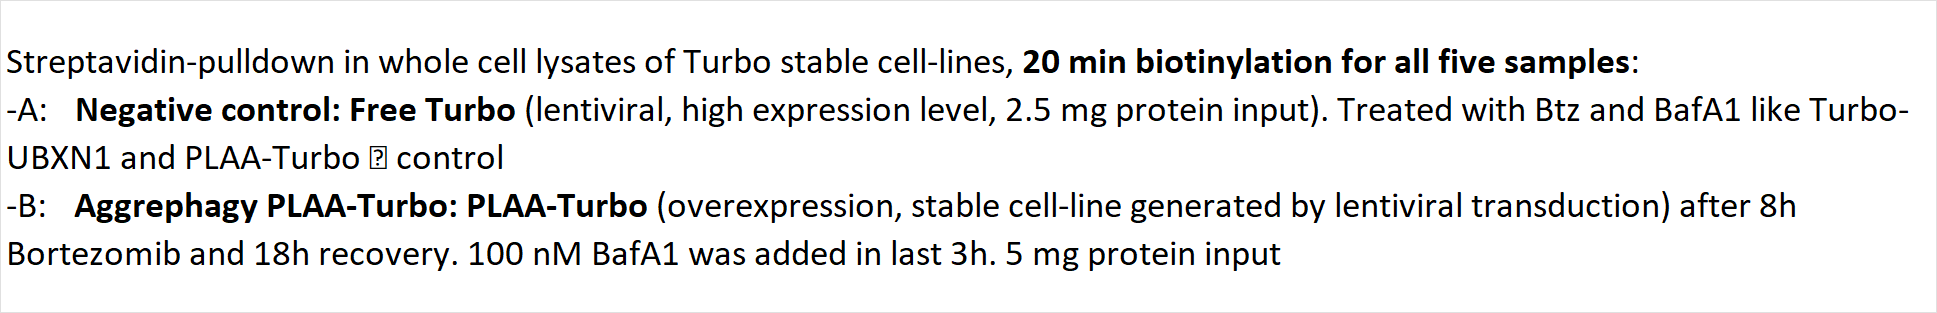

Ratios to caclulate:

- Ratio B vs A (Turbo-PLAA Aggrephagy vs Free-Turbo Aggrephagy)

## Data preprocessing:

In [40]:
df3 = df_merged.copy(deep=True)

### Selecting analysis type:

In [41]:
val = 'log2_Intensity'

In [42]:
val = 'log2_Intensity'

laneA = [val + ' E2-R1-A', val + ' E2-R2-A', val + ' E2-R3-A', val + ' E2-R4-A']

laneB = [val + ' E2-R1-B', val + ' E2-R2-B', val + ' E2-R3-B', val + ' E2-R4-B']


lanes = [laneA, laneB]

sumlanes = laneA + laneB

In [43]:
for lane, i in zip(lanes, range(1,5)):
    df3[lane] = df3[lane].replace(0, np.nan)
    df3 = pp.remove_non_quant(df3, sumlanes)
    df3 = pp.filter_vv(df3, [lane], n=2, valid_values=True)
    ### Filtering for 2/4 reps:
    df_imp = pp.imp_seq(df3, lane)    
    lane = df_imp.filter(regex='_imputed').columns.to_list()
    df_imp, lane = pp.quantile_norm(df_imp, lane, return_cols=True)
    lane = df_imp.filter(regex='_imputed_normalized').columns.to_list()
    # Generate the DataFrame name as a string
    df_name = "df_" + str(i)
    exec(f"{df_name} = df_imp")

3934 rows before filter operation.
3678 rows after filter operation.
3678 rows before filter operation.
3170 rows after filter operation.
3170 rows before filter operation.
3170 rows after filter operation.
3170 rows before filter operation.
2628 rows after filter operation.


### Merging to preserve index:

In [44]:
merge1 = pd.merge(df3, df_1,how="left", on ='id', suffixes=('', '_y'))
merge1.drop(merge1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

merge2 = pd.merge(merge1, df_2,how="left", on ='id', suffixes=('', '_y'))
merge2.drop(merge2.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

merge3 = pd.merge(merge2, df_3,how="left", on ='id', suffixes=('', '_y'))
merge3.drop(merge3.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)


In [45]:
df_exp2 = merge3.copy(deep=True)

### Selecting lanes for ratios:

In [46]:
laneA = ['log2_Intensity.E2.R1.A_imputed_normalized','log2_Intensity.E2.R2.A_imputed_normalized',
       'log2_Intensity.E2.R3.A_imputed_normalized','log2_Intensity.E2.R4.A_imputed_normalized']

laneB = ['log2_Intensity.E2.R1.B_imputed_normalized','log2_Intensity.E2.R2.B_imputed_normalized',
       'log2_Intensity.E2.R3.B_imputed_normalized','log2_Intensity.E2.R4.B_imputed_normalized']

lanes = [laneA, laneB]

### Calculate ratios

For all reps:

In [47]:
for i in range(1,5):
    df_exp2[f"Ratio " + val + " E2 Lane-B vs Lane-A Rep_" + str(i)] = df_exp2[laneB[i-1]] - df_exp2[laneA[i-1]]

### Ratio corr maps:

<Figure size 2000x1000 with 0 Axes>

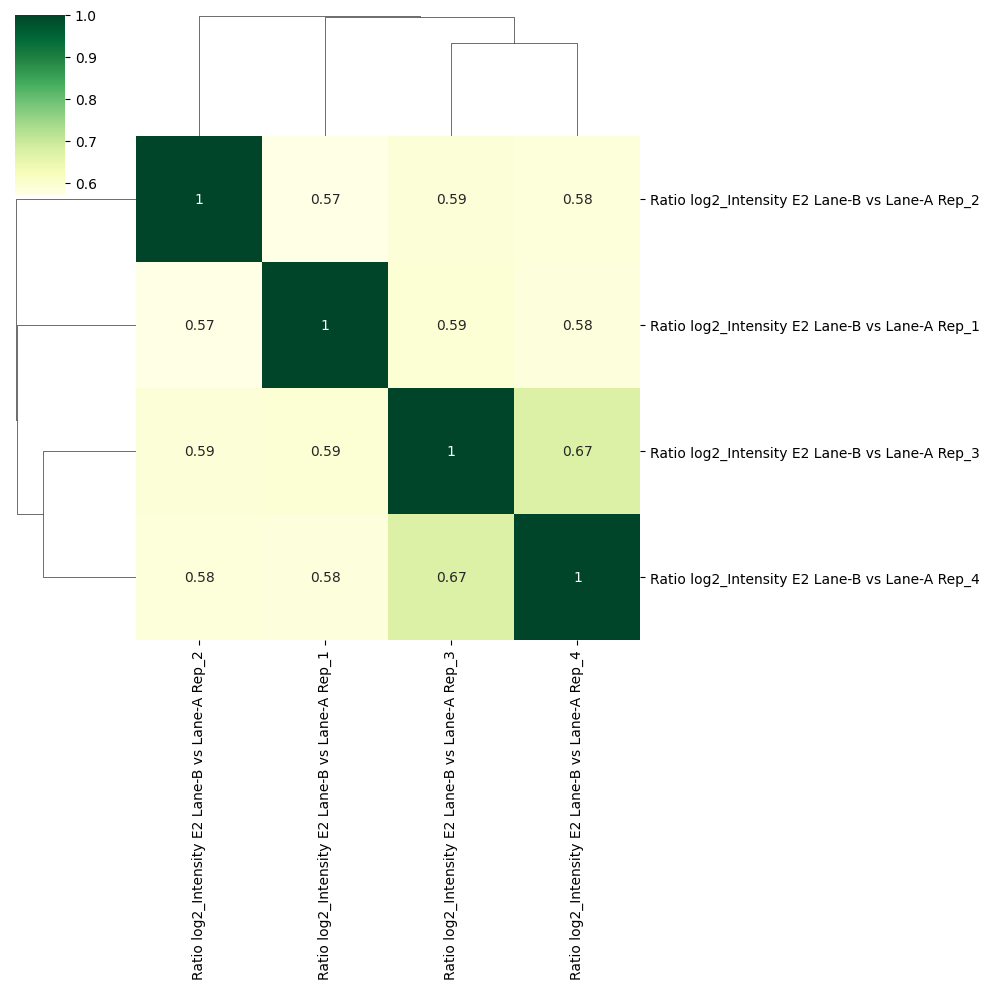

In [48]:
plt.figure(figsize=(20,10))
vis.corr_map(df_exp2, df_exp2.filter(regex='Ratio ').columns.to_list(), cluster=True,
    annot=True)
##plt.savefig(r"F:\EXPERIMENTS\HD_Collaborations\AG_Buchberger\01_AB001_TAX1BP1_TurboID\Rep1_2\plots\RatiovsIntensity_df3.pdf")

### Ratio-Intensity plots:

In [49]:
log_ratio_cols = df_exp2.filter(regex='Ratio log2_Intensity E2 Lane-B vs Lane-A Rep').columns.to_list()

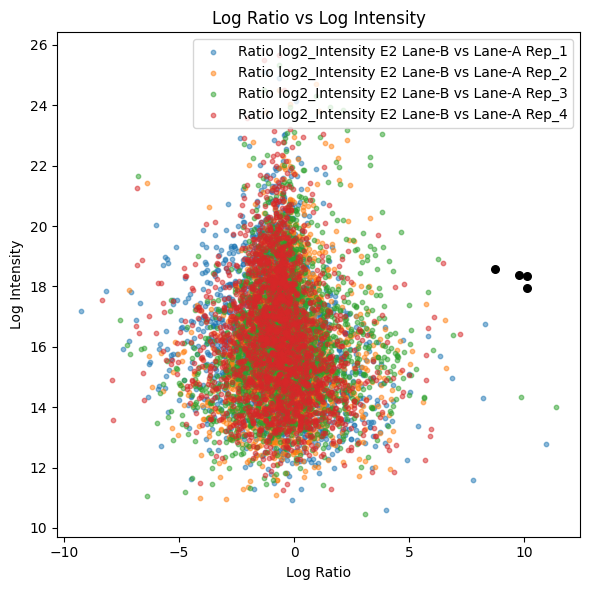

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single plot
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `df_exp2` and `log_ratio_cols` are already defined
int_cols = df_exp2.filter(regex='Intensity ').columns.to_list()

for idx, col in enumerate(log_ratio_cols):
    # Normalized values are plotted on top of the non-normalized values for comparison
    ax.scatter(df_exp2[col],
               np.log(df_exp2[int_cols[idx]]),
               label=col,
               alpha=0.5,
               s=10)
    temp = df_exp2[df_exp2['Gene names 1st'] == "PLAA"]
    ax.scatter(temp[col],
               np.log(temp[int_cols[idx]]),
               label=None,
               alpha=1,
               color='black',
               s=30,
               linewidths=1)

# Set the axis labels, title, and add a legend
ax.set_xlabel('Log Ratio')
ax.set_ylabel('Log Intensity')
ax.set_title('Log Ratio vs Log Intensity')
ax.legend()

plt.tight_layout()
plt.show()


## LIMMA ANALYSIS


In [51]:
Ratio1 = df_exp2.filter(regex='Ratio.*Lane-B vs Lane-A').columns.to_list()
df_exp2_BvsA = pp.filter_vv(df_exp2, [Ratio1], n=2, valid_values=True)
df_exp2_BvsA = ana.limma(df_exp2_BvsA, [Ratio1], cond="_E2_Lane-B vs Lane-A")

2628 rows before filter operation.
2628 rows after filter operation.
LIMMA: Assuming a one sample test


## Volcano Plots:

### Lane-B vs Lane-A

#### With all categories marked:

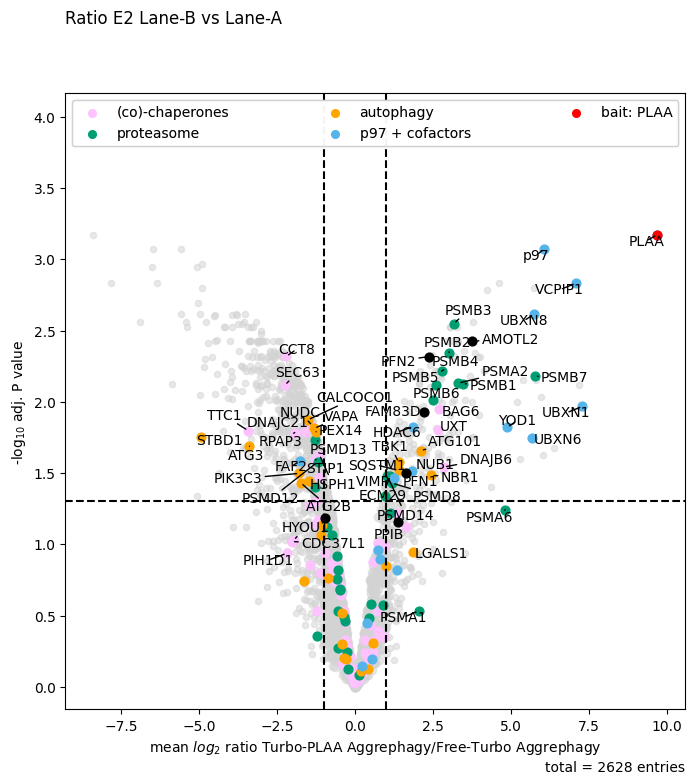

In [52]:
fig = vis.volcano(df_exp2_BvsA,
title = "Ratio E2 Lane-B vs Lane-A",
log_fc_colname="logFC_E2_Lane-B vs Lane-A", 
p_colname="adj.P.Val_E2_Lane-B vs Lane-A",  
p_thresh=0.05,
log_fc_thresh = 1,
# show_legend = False,
annotate_colname='Gene names 1st',
annotate_density = 250,
annotate='highlight', 
highlight=[
        df_exp2_BvsA[df_exp2_BvsA['category']=='co-chaperones'].index,
        df_exp2_BvsA[df_exp2_BvsA['category']=='proteasome'].index,
           df_exp2_BvsA[df_exp2_BvsA['category']=='autophagy'].index,
           df_exp2_BvsA[df_exp2_BvsA['category']=='p97 and cofactors'].index,
           df_exp2_BvsA[df_exp2_BvsA['Gene names 1st']=='PLAA'].index,
        df_exp2_BvsA[df_exp2_BvsA['Gene names 1st'].isin(['AMOTL1', 'AMOTL2', 'FAM83D','PFN1','PFN2'])].index],
kwargs_highlight=[{'color': '#fec2ff', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': '(co)-chaperones', # set highlight label
    },
    {'color': '#009E73', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'proteasome', # set highlight label
    },
    {'color': 'orange', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'autophagy', # set highlight label
    },
    {'color': '#56B4E9', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'p97 + cofactors', # set highlight label
    },
    {'color': 'red', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'bait: PLAA', # set highlight label
    },
    {'color': 'black', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': None, # set highlight label
    },],
kwargs_both_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
            
kwargs_log_fc_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
kwargs_p_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
kwargs_ns={
    'color': 'lightgrey', # set highlight color to red
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    })

# plt.xlim(-.7,1)
# plt.ylim(-0.2,7)

# legend = plt.legend(loc='upper left')


# plt.axvline(x=0.322, color="grey", linestyle="--")
# plt.axvline(x=-0.322, color="grey", linestyle="--")


for ax in fig.get_axes():
    ax.set_xlabel(r"mean $ log_{2}$ ratio Turbo-PLAA Aggrephagy/Free-Turbo Aggrephagy")
    ax.set_ylabel(r"-log$_{10}$ adj. P value")
# plt.savefig("plots/3_Volcano_Turbo-PLAA vs Free-Turbo_highlighted_annotated_v01.pdf")

#### Volcano plot: Plotly

In [53]:
df_exp2_BvsA['negative_p-value'] = np.log10(df_exp2_BvsA['P.Value_E2_Lane-B vs Lane-A']) * (-1)

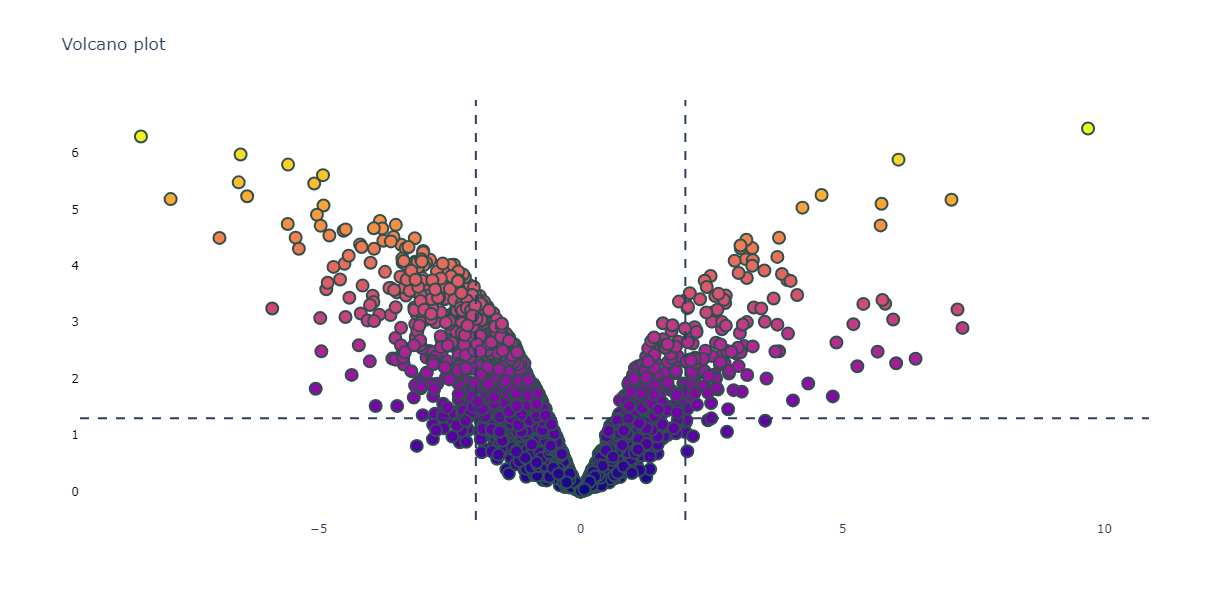

In [54]:
fig = go.Figure()
trace1 = go.Scatter(
 x=df_exp2_BvsA['logFC_E2_Lane-B vs Lane-A'],
 y=df_exp2_BvsA['negative_p-value'],
 mode='markers',
    marker_color=df_exp2_BvsA['negative_p-value'],
 name='6hrs',
 hovertext=list(df_exp2_BvsA["Gene names"])
)

fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
# fig.add_trace(trace4)
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.add_hline(y=1.3, line_dash="dash")
fig.add_vline(x=2, line_dash="dash")
fig.add_vline(x=-2, line_dash="dash")
fig.update_layout(title='Volcano plot',
                 autosize=False,
                 width=800,
                 height=600)
fig.update_layout(plot_bgcolor="white")
fig.update_yaxes(color='black', layer='above traces')
fig.show()

# Experiment 3: Identification of proximity partners of UBXN1:

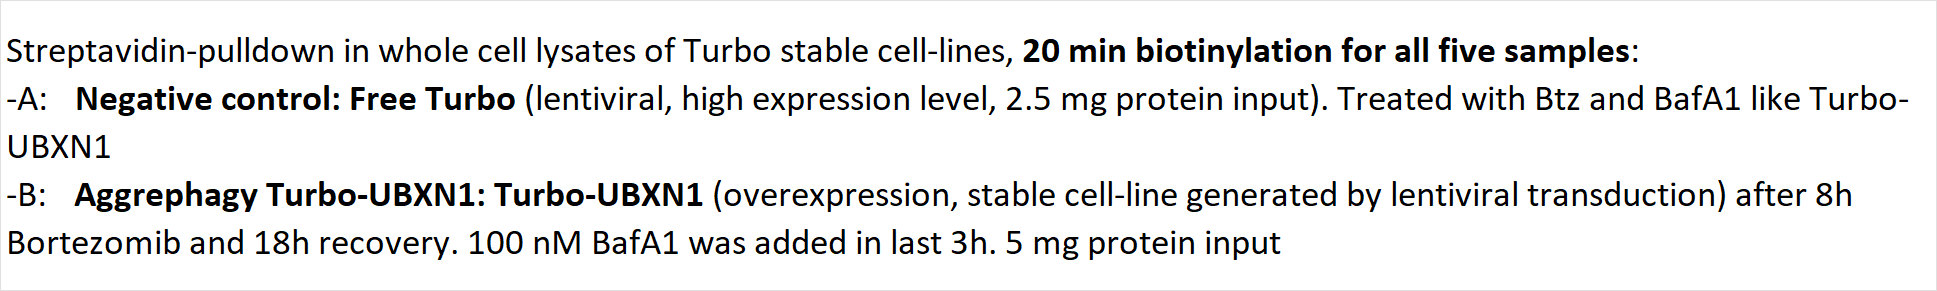

Ratios to caclulate:

- Ratio B vs A (Turbo-UBXN1 Aggrephagy vs Free-Turbo Aggrephagy)

## Data preprocessing:

In [55]:
df3 = df_merged.copy(deep=True)

### Selecting analysis type:

In [56]:
val = 'log2_Intensity'

In [57]:
val = 'log2_Intensity'

laneA = [val + ' E3-R1-A', val + ' E3-R2-A', val + ' E3-R3-A']

laneB = [val + ' E3-R1-B', val + ' E3-R2-B', val + ' E3-R3-B']


lanes = [laneA, laneB]

sumlanes = laneA + laneB

In [58]:
for lane, i in zip(lanes, range(1,4)):
    df3[lane] = df3[lane].replace(0, np.nan)
    df3 = pp.remove_non_quant(df3, sumlanes)
    df3 = pp.filter_vv(df3, [lane], n=1, valid_values=True)
    ### Filtering for 1/3 reps:
    df_imp = pp.imp_seq(df3, lane)    
    lane = df_imp.filter(regex='_imputed').columns.to_list()
    df_imp, lane = pp.quantile_norm(df_imp, lane, return_cols=True)
    lane = df_imp.filter(regex='_imputed_normalized').columns.to_list()
    # Generate the DataFrame name as a string
    df_name = "df_" + str(i)
    exec(f"{df_name} = df_imp")

3934 rows before filter operation.
2913 rows after filter operation.
2913 rows before filter operation.
2771 rows after filter operation.
2771 rows before filter operation.
2771 rows after filter operation.
2771 rows before filter operation.
2053 rows after filter operation.


### Merging to preserve index:

In [59]:
merge1 = pd.merge(df3, df_1,how="left", on ='id', suffixes=('', '_y'))
merge1.drop(merge1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

merge2 = pd.merge(merge1, df_2,how="left", on ='id', suffixes=('', '_y'))
merge2.drop(merge2.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

merge3 = pd.merge(merge2, df_3,how="left", on ='id', suffixes=('', '_y'))
merge3.drop(merge3.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [60]:
df_exp3 = merge3.copy(deep=True)

### Selecting lanes for ratios:

In [61]:
laneA = ['log2_Intensity.E3.R1.A_imputed_normalized','log2_Intensity.E3.R2.A_imputed_normalized','log2_Intensity.E3.R3.A_imputed_normalized']

laneB = ['log2_Intensity.E3.R1.B_imputed_normalized','log2_Intensity.E3.R2.B_imputed_normalized','log2_Intensity.E3.R3.B_imputed_normalized']

lanes = [laneA, laneB]

### Calculate ratios

For all reps:

In [62]:
for i in range(1,4):
    df_exp3[f"Ratio " + val + " E3 Lane-B vs Lane-A Rep_" + str(i)] = df_exp3[laneB[i-1]] - df_exp3[laneA[i-1]]

### Ratio corr maps:

<Figure size 2000x1000 with 0 Axes>

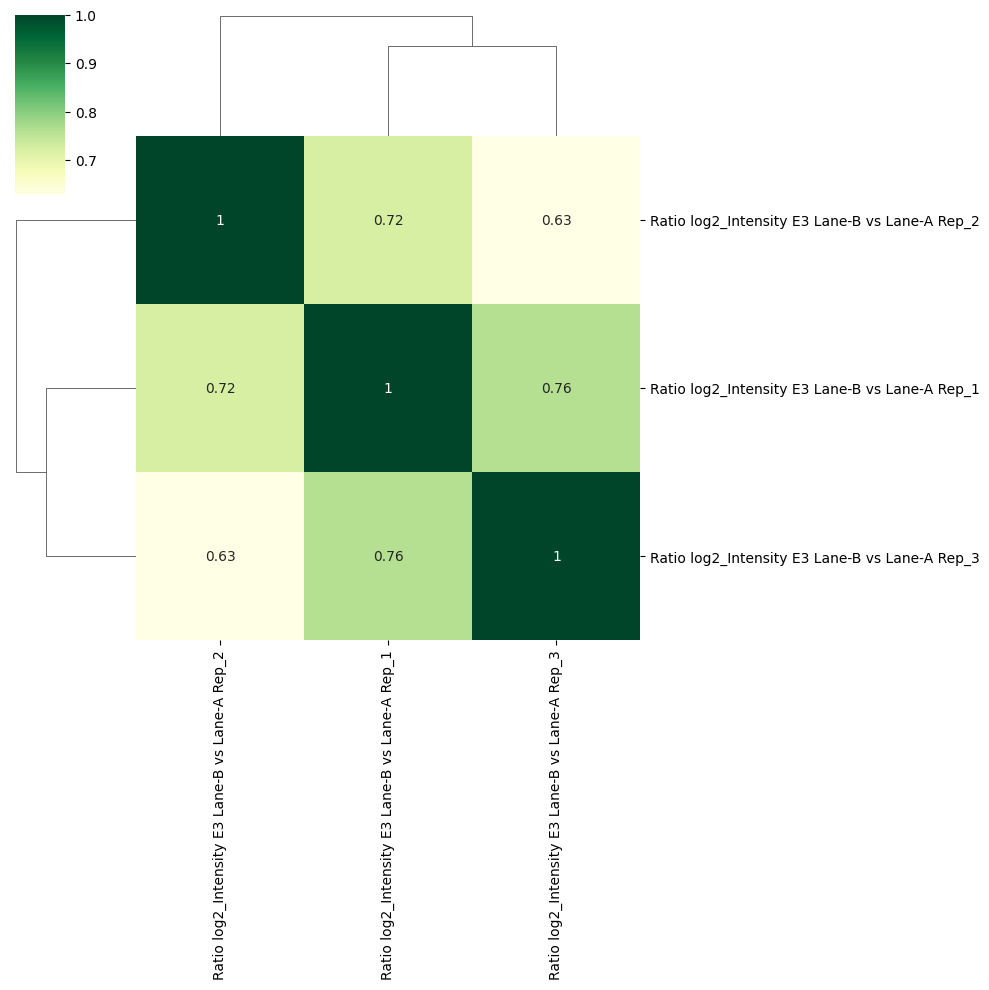

In [63]:
plt.figure(figsize=(20,10))
vis.corr_map(df_exp3, df_exp3.filter(regex='Ratio ').columns.to_list(), cluster=True,
    annot=True)
##plt.savefig(r"F:\EXPERIMENTS\HD_Collaborations\AG_Buchberger\01_AB001_TAX1BP1_TurboID\Rep1_2\plots\RatiovsIntensity_df3.pdf")

### Ratio-Intensity plots:

In [64]:
log_ratio_cols = df_exp3.filter(regex='Ratio log2_Intensity E3 Lane-B vs Lane-A Rep').columns.to_list()

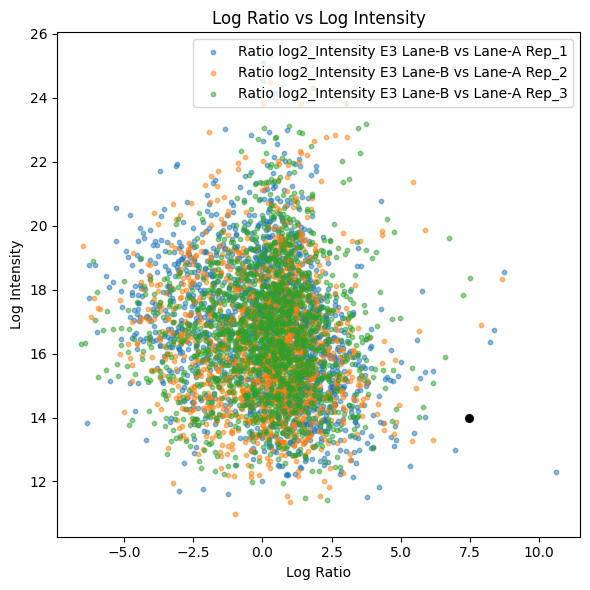

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single plot
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `df_exp3` and `log_ratio_cols` are already defined
int_cols = df_exp3.filter(regex='Intensity ').columns.to_list()

for idx, col in enumerate(log_ratio_cols):
    # Normalized values are plotted on top of the non-normalized values for comparison
    ax.scatter(df_exp3[col],
               np.log(df_exp3[int_cols[idx]]),
               label=col,
               alpha=0.5,
               s=10)
    temp = df_exp3[df_exp3['Gene names 1st'] == "UBXN1"]
    ax.scatter(temp[col],
               np.log(temp[int_cols[idx]]),
               label=None,
               alpha=1,
               color='black',
               s=30,
               linewidths=1)

# Set the axis labels, title, and add a legend
ax.set_xlabel('Log Ratio')
ax.set_ylabel('Log Intensity')
ax.set_title('Log Ratio vs Log Intensity')
ax.legend()

plt.tight_layout()
plt.show()


## LIMMA ANALYSIS


In [66]:
Ratio1 = df_exp3.filter(regex='Ratio.*Lane-B vs Lane-A').columns.to_list()
df_exp3_BvsA = pp.filter_vv(df_exp3, [Ratio1], n=1, valid_values=True)
df_exp3_BvsA = ana.limma(df_exp3_BvsA, [Ratio1], cond="_E3_Lane-B vs Lane-A")

2053 rows before filter operation.
2053 rows after filter operation.
LIMMA: Assuming a one sample test


## Volcano Plots:

### Lane-B vs Lane-A

#### With all categories marked:

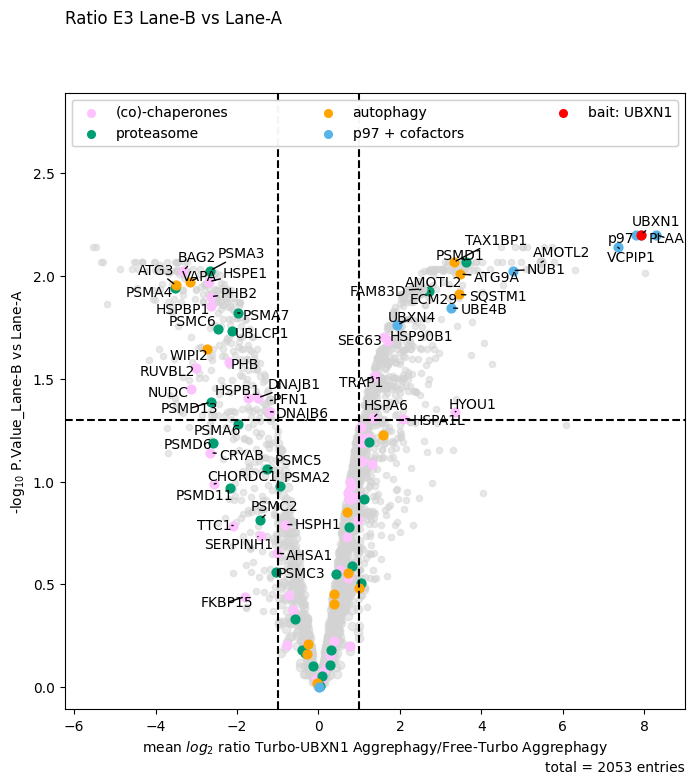

In [67]:
fig = vis.volcano(df_exp3_BvsA,
title = "Ratio E3 Lane-B vs Lane-A",
log_fc_colname="logFC_E3_Lane-B vs Lane-A",
p_colname="adj.P.Val_E3_Lane-B vs Lane-A",  
p_thresh=0.05,
log_fc_thresh = 1,
# show_legend = False,
annotate_colname='Gene names 1st',
annotate_density = 150,
annotate='highlight', 
highlight=[
        df_exp3_BvsA[df_exp3_BvsA['category']=='co-chaperones'].index,
        df_exp3_BvsA[df_exp3_BvsA['category']=='proteasome'].index,
           df_exp3_BvsA[df_exp3_BvsA['category']=='autophagy'].index,
           df_exp3_BvsA[df_exp3_BvsA['category']=='p97 and cofactors'].index,
           df_exp3_BvsA[df_exp3_BvsA['Gene names 1st']=='UBXN1'].index,
        df_exp3_BvsA[df_exp3_BvsA['Gene names 1st'].isin(['AMOTL1', 'AMOTL2', 'FAM83D','PFN1','PFN2'])].index],
kwargs_highlight=[{'color': '#fec2ff', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': '(co)-chaperones', # set highlight label
    },
    {'color': '#009E73', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'proteasome', # set highlight label
    },
    {'color': 'orange', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'autophagy', # set highlight label
    },
    {'color': '#56B4E9', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'p97 + cofactors', # set highlight label
    },
    {'color': 'red', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': 'bait: UBXN1', # set highlight label
    },
    {'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 40, # set highlight size to 100
    'alpha': 1, # set highlight alpha to 0.8
    'label': None, # set highlight label
    },],
kwargs_both_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
            
kwargs_log_fc_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
kwargs_p_sig={
    'color': 'lightgrey', # set highlight color to red
    'marker': 'o', # set highlight shape to circle
    's': 20, # set highlight size to 100
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    },
kwargs_ns={
    'color': 'lightgrey', # set highlight color to red
    'alpha': 0.5, # set highlight alpha to 0.8
    'label': None
    })

for ax in fig.get_axes():
    ax.set_xlabel(r"mean $ log_{2}$ ratio Turbo-UBXN1 Aggrephagy/Free-Turbo Aggrephagy")
    ax.set_ylabel(r"-log$_{10}$ P.Value_Lane-B vs Lane-A")
plt.savefig("plots/4_Volcano_Turbo-UBXN1 vs Free-Turbo_highlighted_annotated_v01.pdf")

#### Volcano plot: Plotly

In [68]:
df_exp3_BvsA['negative_p-value'] = np.log10(df_exp3_BvsA['adj.P.Val_E3_Lane-B vs Lane-A']) * (-1)

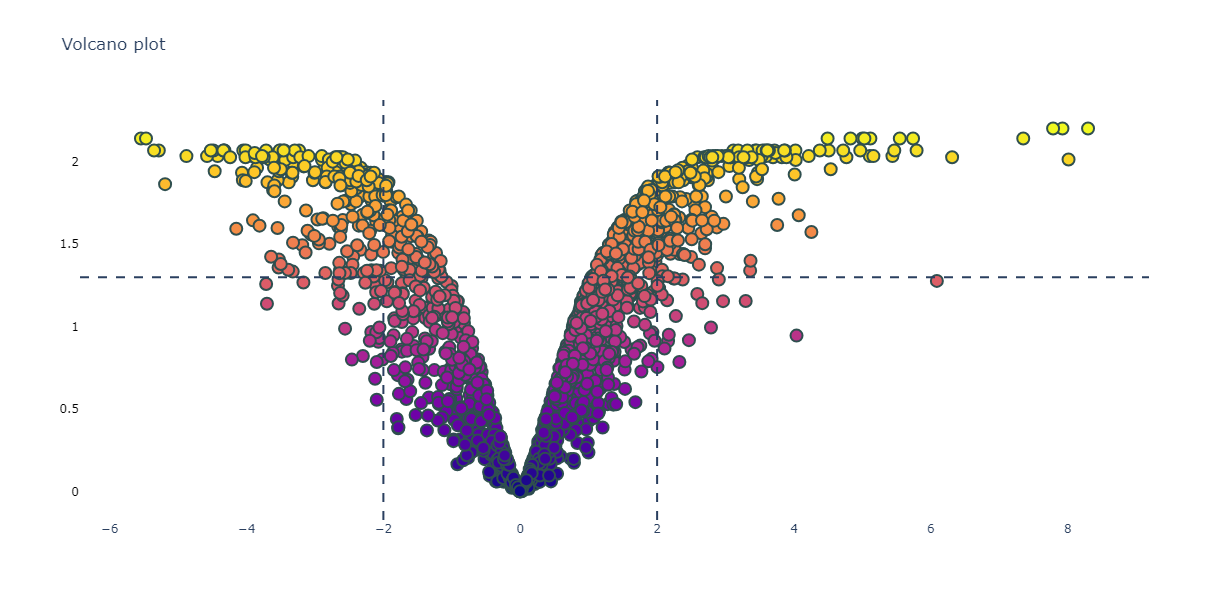

In [69]:
fig = go.Figure()
trace1 = go.Scatter(
 x=df_exp3_BvsA['logFC_E3_Lane-B vs Lane-A'],
 y=df_exp3_BvsA['negative_p-value'],
 mode='markers',
    marker_color=df_exp3_BvsA['negative_p-value'],
 name='6hrs',
 hovertext=list(df_exp3_BvsA["Gene names"])
)

fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
# fig.add_trace(trace4)
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.add_hline(y=1.3, line_dash="dash")
fig.add_vline(x=2, line_dash="dash")
fig.add_vline(x=-2, line_dash="dash")
fig.update_layout(title='Volcano plot',
                 autosize=False,
                 width=800,
                 height=600)
fig.update_layout(plot_bgcolor="white")
fig.update_yaxes(color='black', layer='above traces')
fig.show()

# Merging of all datasets:

In [70]:
merge1 = pd.merge(df_merged, df_exp1_CvsA, how="left", on ='id', suffixes=('', '_y'))
merge1.drop(merge1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [71]:
merge2 = pd.merge(merge1, df_exp1_CvsB, how="left", on ='id', suffixes=('', '_y'))
merge2.drop(merge2.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [72]:
merge3 = pd.merge(merge2, df_exp2_BvsA, how="left", on ='id', suffixes=('', '_y'))
merge3.drop(merge3.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [73]:
merge4 = pd.merge(merge3, df_exp3_BvsA, how="left", on ='id', suffixes=('', '_y'))
merge4.drop(merge4.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

# Data export:

In [74]:
merge4.to_excel("results/Results_TAX1BP1_PLAA_UBXN1_proximitome.xlsx", index=False)

In [75]:
# merge4.to_csv("results/Results_TAX1BP1_PLAA_UBXN1_proximitome_hd_v01.csv", index=False)